### Explaining a black box classifier for three-body encounter outcomes

The goal is to train a classifier to predict the outcome of a binary-single collision based on features related to the initial conditions. The problem is framed as a four-class classification based on the outcome: fly-by, exchange with the primary binary member, exchange with the secondary, full ionization. We could conceive the outcome as an ordinal variable, but we are refraining from doing that at this stage.

In the following I will subdivide the data into a training, validation and test set and I will train an extratree classifier. Then I will attempt to use the anchor eplanation method for some instances, with mixed results.

In [1]:
#usual imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#sklearn imports for building the classifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#xai tools from alibi
from alibi.utils import gen_category_map
from alibi.explainers import AnchorTabular
from alibi.explainers import PartialDependence

In [2]:
X = pd.read_csv('triple.csv').iloc[:,[1,2,3,4,5,6,8,9,10,11,12,18]]
X.head()

/var/folders/8w/66mbmptd4ws3j45r5hp0c6w80000gn/T/ipykernel_2551/1215199486.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  X = pd.read_csv('triple.csv').iloc[:,[1,2,3,4,5,6,8,9,10,11,12,18]]


m1        m2        m3         a         e         b       phi  \
0   8.94105   6.31763   9.46617  0.000176  0.847139  0.000116  4.251158   
1  20.17026   9.11588   5.99047  0.000089  0.550558  0.000146  0.702262   
2  23.14852  21.05892   8.81766  0.000185  0.837879  0.000125  1.073307   
3  10.69619   5.93534   6.29361  0.000605  0.787636  0.000295  3.616073   
4  43.14132   7.97408  15.33447  0.000047  0.603927  0.000077  5.555324   

      theta       psi         f          v  OUTCOME  
0  1.059945  5.709111 -2.155132  42.931532        3  
1  1.793509  4.115879 -2.645589  27.488638        0  
2  1.813798  1.785175  2.811754  44.847478        0  
3  1.720063  5.865210  2.689733  26.233562        0  
4  2.458394  1.595215  2.563572  43.560640        2

In [3]:
X.describe()

m1             m2             m3             a  \
count  100000.000000  100000.000000  100000.000000  1.000000e+05   
mean       27.984847      13.769848      20.845119  6.191543e-04   
std        13.106164       8.079919      12.982459  1.494302e-03   
min         5.730730       3.005940       3.014130  6.113618e-07   
25%        18.932157       7.676935       9.357190  1.518781e-05   
50%        26.427370      10.669075      18.901930  9.186807e-05   
75%        37.705758      18.918057      28.142903  5.149430e-04   
max        75.128950      58.464870      78.460900  2.994969e-02   

                   e             b            phi          theta  \
count  100000.000000  1.000000e+05  100000.000000  100000.000000   
mean        0.665449  3.327037e-04       3.145013       1.570635   
std         0.236105  5.921811e-04       1.815987       0.683842   
min         0.004134  1.441093e-07       0.000015       0.009744   
25%         0.497996  5.424888e-05       1.570807       1.049151   
50%         0.705866  1.404062e-04       3.150463       1.572594   
75%         0.864968  3.701744e-04       4.720481       2.092955   
max         0.999992  2.771399e-02       6.283147       3.137020   

                 psi              f              v        OUTCOME  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean        3.142999      -0.012544      31.924987       0.872630  
std         1.812727       2.575070      13.462971       1.099518  
min         0.000007      -3.141582       0.735486       0.000000  
25%         1.581838      -2.747115      22.070797       0.000000  
50%         3.134953      -0.072209      30.769478       0.000000  
75%         4.715834       2.743592      40.556768       1.000000  
max         6.283151       3.141588     105.303915       3.000000

Introducing more physically meaningful features may (or may not) help our performance. But it will definitely make the anchor explanations more understandable and concise. Remember that units of measurement are arbitrary and only ratios matter.

In [4]:
M = X["m1"] + X["m2"]
intruder_to_total_mass_ratio = X["m3"]/(M+X["m3"])
secondary_to_binary_mass_ratio = X["m2"]/M
b_to_a_ratio = X["b"]/X["a"]
escape_velocity_at_b = np.sqrt(4300.0*M/X["b"]) #using G in solar units, maybe wrong but who cares, it's just a rescale
velocity_ratio = X["v"]/escape_velocity_at_b

features = pd.DataFrame({"intruder_to_total_mass_ratio":intruder_to_total_mass_ratio, "secondary_to_binary_mass_ratio":secondary_to_binary_mass_ratio,
                        #"b_to_a_ratio":b_to_a_ratio, "velocity_ratio":velocity_ratio, "e":X["e"], "cos_phi_minus_psi":np.cos(X["phi"] - X["psi"]), "cos_theta":np.cos(X["theta"]), "sin_phi_minus_psi":np.sin(X["phi"] - X["psi"]), "f":X["f"]})
                        "b_to_a_ratio":b_to_a_ratio, "velocity_ratio":velocity_ratio, "e":X["e"], "cos_phi":np.cos(X["phi"]), "cos_theta":np.cos(X["theta"]), "cos_psi":np.cos(X["psi"]), "sin_phi":np.sin(X["phi"]), "sin_psi":np.sin(X["psi"]), "f":X["f"]})

y = X["OUTCOME"]

features.describe()

intruder_to_total_mass_ratio  secondary_to_binary_mass_ratio  \
count                 100000.000000                   100000.000000   
mean                       0.333019                        0.335240   
std                        0.159707                        0.106719   
min                        0.045976                        0.054128   
25%                        0.202921                        0.252305   
50%                        0.313504                        0.342078   
75%                        0.443398                        0.427802   
max                        0.842661                        0.499998   

        b_to_a_ratio  velocity_ratio              e        cos_phi  \
count  100000.000000   100000.000000  100000.000000  100000.000000   
mean        3.410993        0.001040       0.665449       0.002194   
std         5.397954        0.000641       0.236105       0.706696   
min         0.002566        0.000021       0.004134      -1.000000   
25%         0.614197        0.000542       0.497996      -0.704413   
50%         1.543106        0.000881       0.705866       0.004167   
75%         3.993660        0.001402       0.864968       0.707173   
max        96.819863        0.004734       0.999992       1.000000   

           cos_theta        cos_psi        sin_phi        sin_psi  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       -0.000136      -0.000967      -0.001032       0.001241   
std         0.577292       0.707601       0.707520       0.706618   
min        -0.999990      -1.000000      -1.000000      -1.000000   
25%        -0.498752      -0.709309      -0.710319      -0.703134   
50%        -0.001798      -0.003440      -0.003992       0.002845   
75%         0.498307       0.708443       0.706102       0.707089   
max         0.999953       1.000000       1.000000       1.000000   

                   f  
count  100000.000000  
mean       -0.012544  
std         2.575070  
min        -3.141582  
25%        -2.747115  
50%        -0.072209  
75%         2.743592  
max         3.141588

From here on we set aside a test set that we will never touch anymore. This way we can be sure that there is no data leakage and we are fairly assessing the performance of the classifier even if we optimize hyperparameters in validation. This is very important if our main goal is to predict the outcome and to know how accurate our predition is. In our case it is still important but we focus more on explaining the classifier.

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(features, y, random_state=888)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=888)

In [6]:
xtc = ExtraTreesClassifier(n_estimators=300, random_state=888)
xtc.fit(X_train, y_train)

print(accuracy_score(xtc.predict(X_val), y_val))
print(confusion_matrix(xtc.predict(X_val), y_val))

0.69008
[[8289 1439  524 1028]
 [ 874 2562  735   87]
 [ 101  157  410   52]
 [ 533  114  167 1678]]


/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


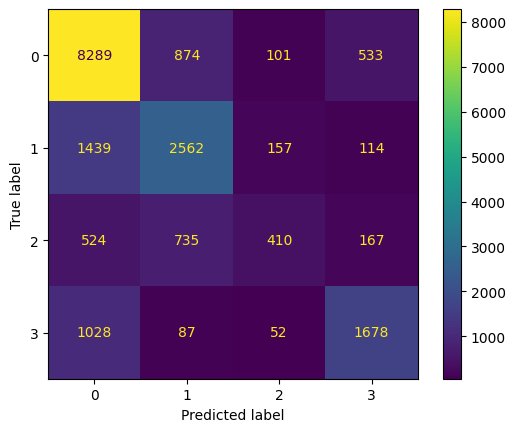

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xtc, X_val, y_val)
plt.show()

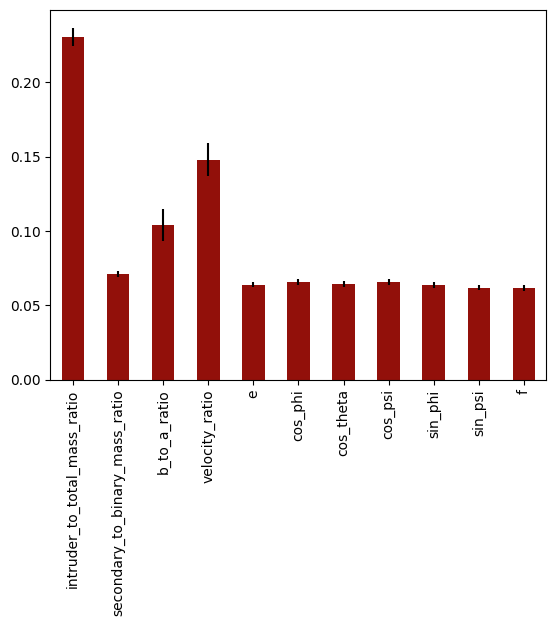

In [7]:
std = np.std([tree.feature_importances_ for tree in xtc.estimators_], axis=0)
pd.Series(xtc.feature_importances_, index=X_train.columns).plot.bar(color="#92100A", yerr=std)
plt.show()

In [8]:
from alibi.utils import gen_category_map
from alibi.explainers import AnchorTabular
from alibi.explainers import PartialDependence
xtc.fit(X_train.values, y_train.values) #without .values I get a warning here*

ExtraTreesClassifier(n_estimators=300, random_state=888)

In [9]:
def disc_perc_gen(N):
    return np.arange(N-1)/N + (1.0/N)
    
disc_perc_gen(10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [10]:
category_map = gen_category_map(X_train)
feature_names = X_train.columns
predict_fn = lambda x: xtc.predict(x)
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map) #*
explainer.fit(X_train.to_numpy(), disc_perc=disc_perc_gen(10))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}
            ,
  'version': '0.8.0'}
)

In [11]:
def explain_this(i, X, y):
    explanation = explainer.explain(X.to_numpy()[i,:], threshold=0.8)
    return (i, X.iloc[i,:], y.iloc[i], explanation.coverage, explanation.precision, explanation.anchor)

In [12]:
explain_this(6, X_train, y_train)

Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


(6,
 intruder_to_total_mass_ratio      0.312954
 secondary_to_binary_mass_ratio    0.160154
 b_to_a_ratio                      1.586866
 velocity_ratio                    0.000935
 e                                 0.202113
 cos_phi                          -0.479519
 cos_theta                         0.610127
 cos_psi                           0.126375
 sin_phi                           0.877532
 sin_psi                          -0.991983
 f                                -0.883922
 Name: 38104, dtype: float64,
 0,
 0.9625244444444444,
 0.5821620240224892,
 ['intruder_to_total_mass_ratio > 0.06',
  'velocity_ratio > 0.00',
  'cos_theta > -0.99',
  'cos_phi > -1.00',
  'b_to_a_ratio > 0.03',
  'secondary_to_binary_mass_ratio > 0.11',
  'sin_phi > -1.00',
  'cos_psi > -1.00',
  'sin_psi > -1.00'])

In [13]:
explain_this(11, X_train, y_train)

Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


(11,
 intruder_to_total_mass_ratio      0.652693
 secondary_to_binary_mass_ratio    0.489707
 b_to_a_ratio                      1.435591
 velocity_ratio                    0.001941
 e                                 0.969562
 cos_phi                          -0.997396
 cos_theta                        -0.120017
 cos_psi                           0.716873
 sin_phi                           0.072114
 sin_psi                          -0.697204
 f                                -2.958197
 Name: 69372, dtype: float64,
 0,
 0.9555733333333334,
 0.5794797687861272,
 ['velocity_ratio > 0.00',
  'cos_psi > -1.00',
  'cos_phi > -1.00',
  'sin_phi > -1.00',
  'sin_psi > -1.00',
  'e > 0.08',
  'cos_theta > -0.98'])

In [14]:
explain_this(0, X_train, y_train)

Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


(0,
 intruder_to_total_mass_ratio      0.755644
 secondary_to_binary_mass_ratio    0.450211
 b_to_a_ratio                      1.209065
 velocity_ratio                    0.001289
 e                                 0.753772
 cos_phi                           0.347910
 cos_theta                        -0.634185
 cos_psi                          -0.729765
 sin_phi                          -0.937528
 sin_psi                          -0.683698
 f                                 0.975743
 Name: 49880, dtype: float64,
 1,
 0.9502222222222222,
 0.2490885226775558,
 ['b_to_a_ratio > 0.08',
  'intruder_to_total_mass_ratio > 0.08',
  'f > -3.13',
  'cos_theta > -0.98',
  'cos_phi > -1.00',
  'sin_psi > -1.00',
  'velocity_ratio > 0.00',
  'cos_psi > -1.00'])

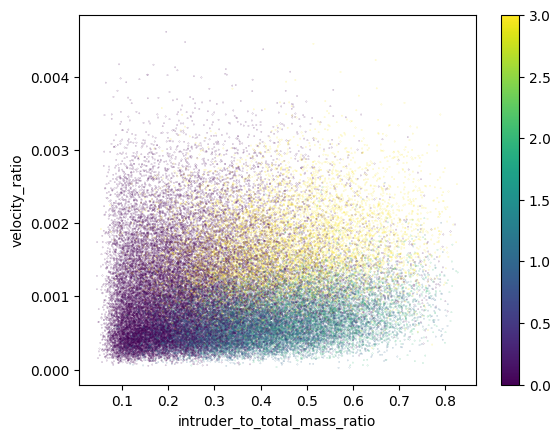

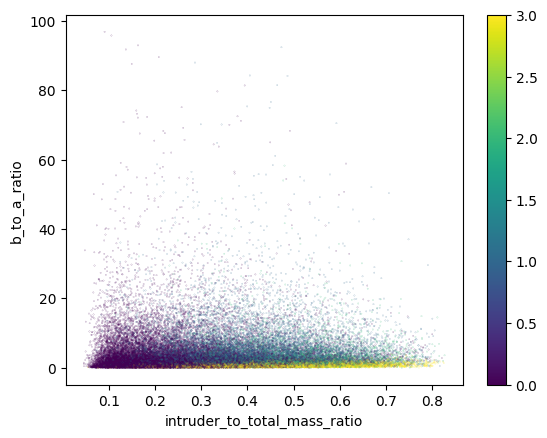

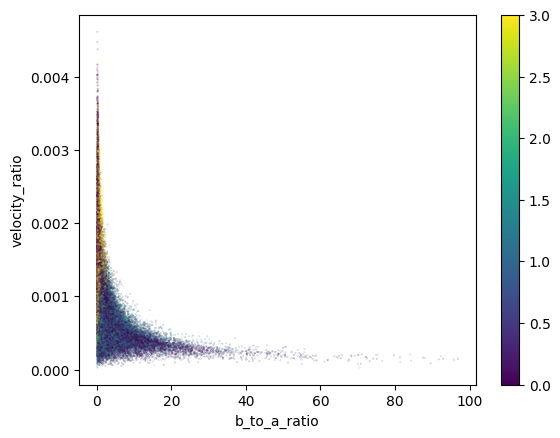

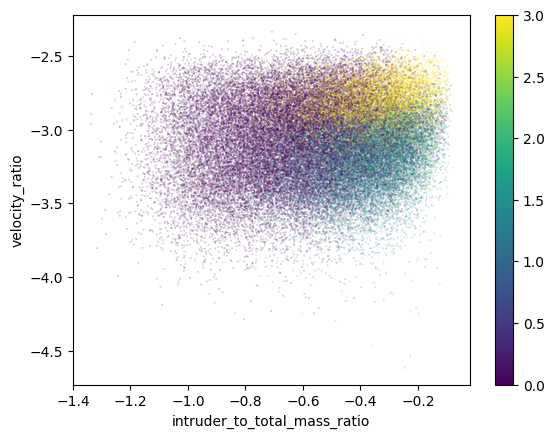

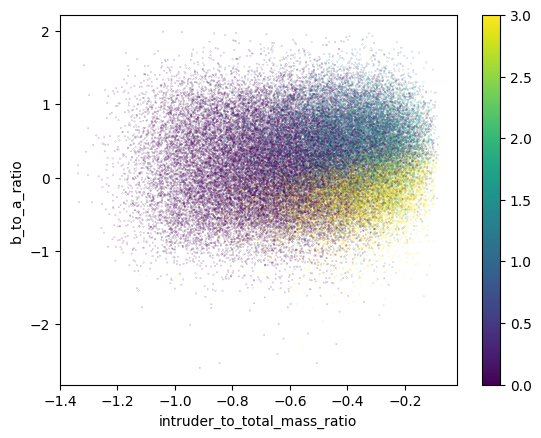

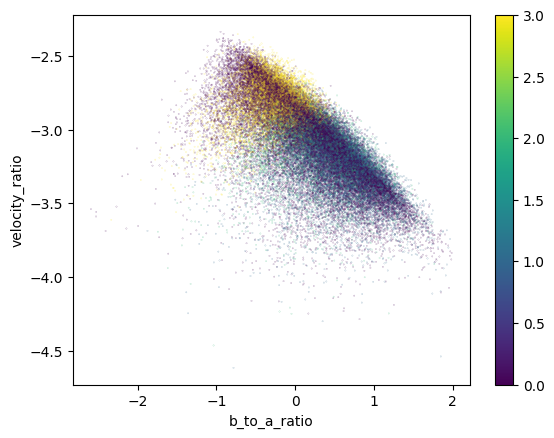

In [23]:
plt.scatter(X_train["intruder_to_total_mass_ratio"], X_train["velocity_ratio"], c = y_train, s=0.01)
plt.xlabel("intruder_to_total_mass_ratio")
plt.ylabel("velocity_ratio")
plt.colorbar()
plt.show()

plt.scatter(X_train["intruder_to_total_mass_ratio"], X_train["b_to_a_ratio"], c = y_train, s=0.01)
plt.xlabel("intruder_to_total_mass_ratio")
plt.ylabel("b_to_a_ratio")
plt.colorbar()
plt.show()

plt.scatter(X_train["b_to_a_ratio"], X_train["velocity_ratio"], c = y_train, s=0.01)
plt.xlabel("b_to_a_ratio")
plt.ylabel("velocity_ratio")
plt.colorbar()
plt.show()

plt.scatter(np.log10(X_train["intruder_to_total_mass_ratio"]), np.log10(X_train["velocity_ratio"]), c = y_train, s=0.01)
plt.xlabel("intruder_to_total_mass_ratio")
plt.ylabel("velocity_ratio")
plt.colorbar()
plt.show()

plt.scatter(np.log10(X_train["intruder_to_total_mass_ratio"]), np.log10(X_train["b_to_a_ratio"]), c = y_train, s=0.01)
plt.xlabel("intruder_to_total_mass_ratio")
plt.ylabel("b_to_a_ratio")
plt.colorbar()
plt.show()

plt.scatter(np.log10(X_train["b_to_a_ratio"]), np.log10(X_train["velocity_ratio"]), c = y_train, s=0.01)
plt.xlabel("b_to_a_ratio")
plt.ylabel("velocity_ratio")
plt.colorbar()
plt.show()

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/fairabbas/lib/python3.10/site-packa

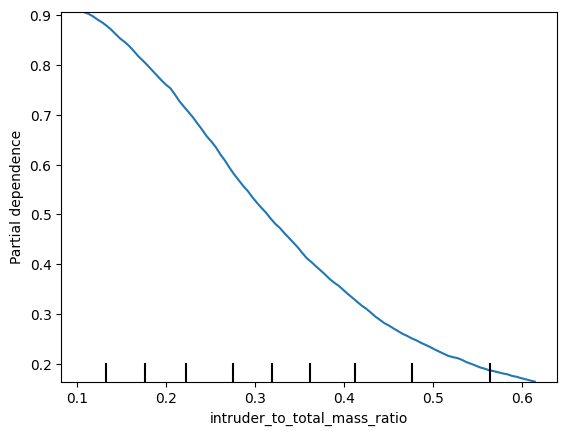

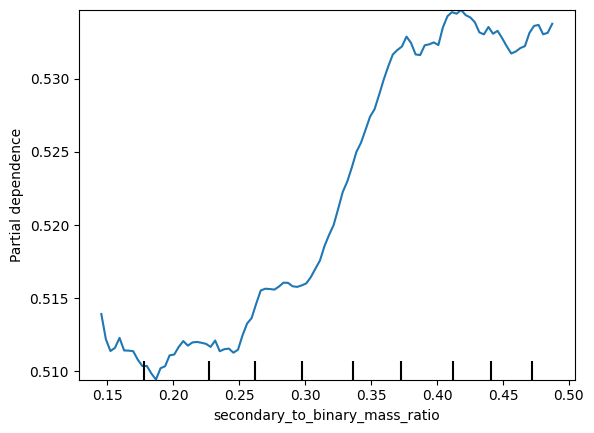

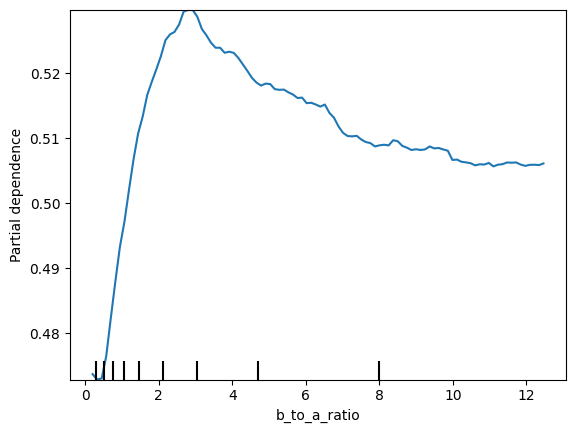

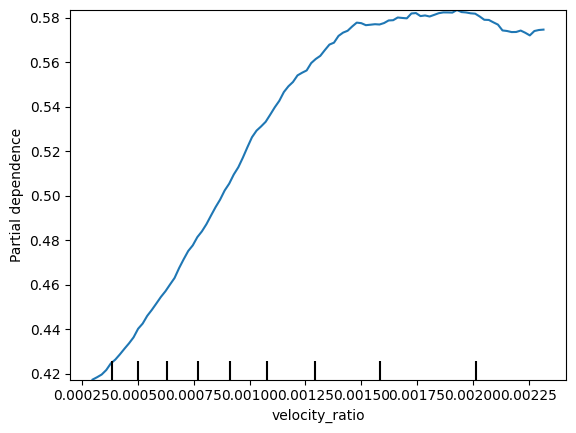

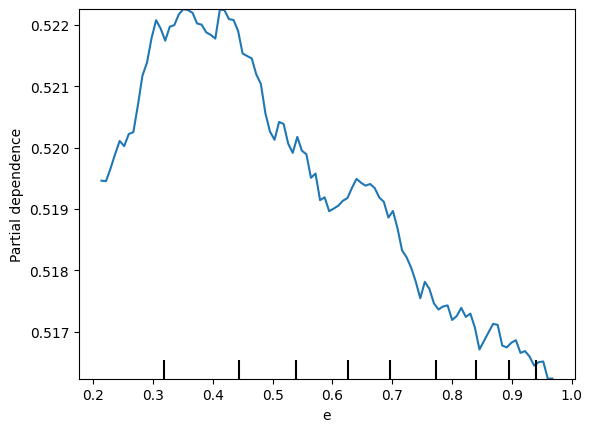

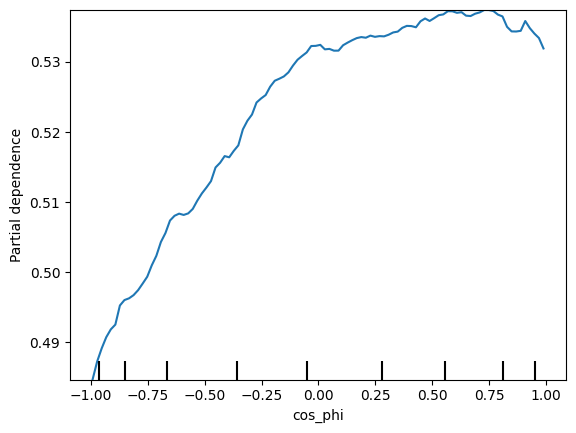

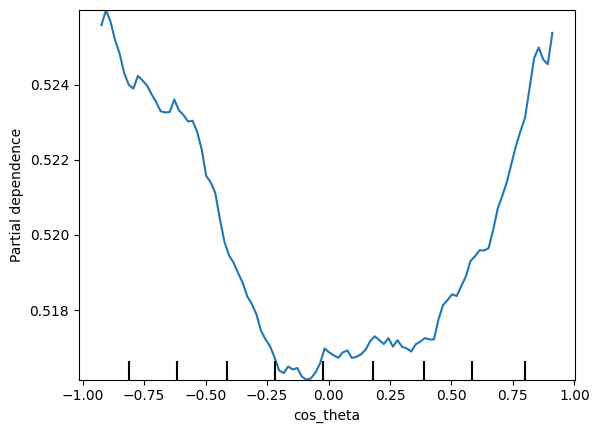

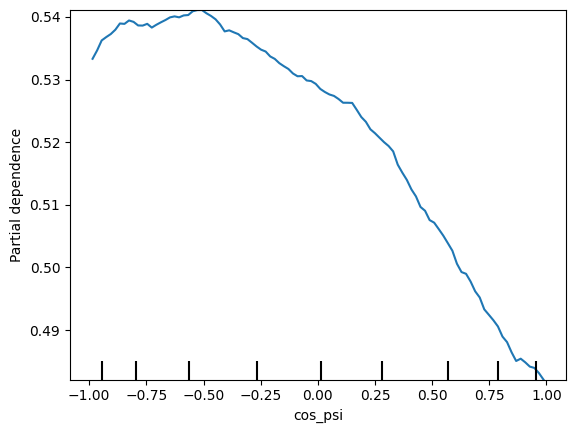

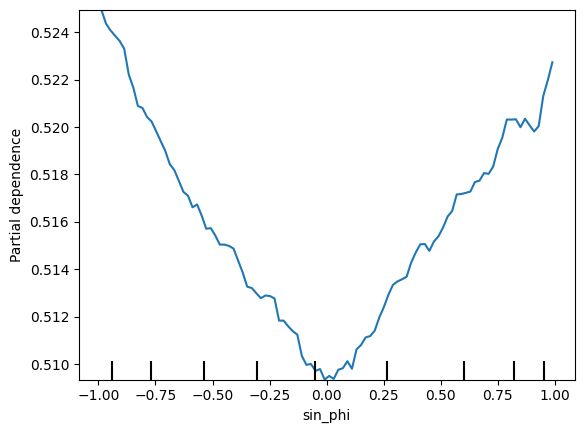

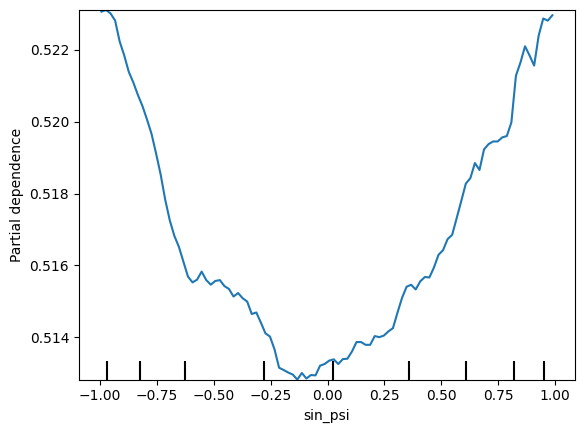

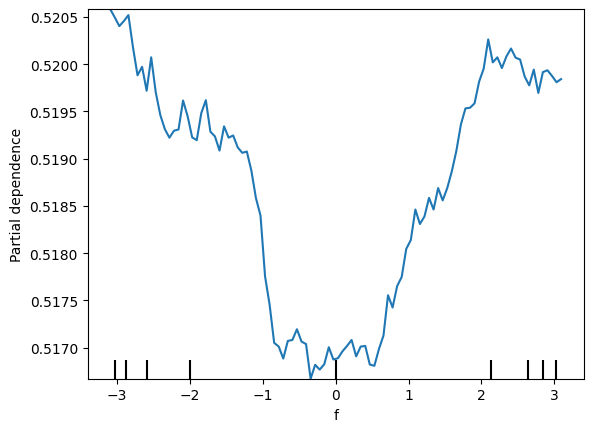

In [16]:
from sklearn.inspection import PartialDependenceDisplay
for h in range(X_val.shape[1]):
    disp1 = PartialDependenceDisplay.from_estimator(xtc, X_val.iloc[1:1000,:], [h,], target = [0,])

In [19]:
individual = np.concatenate([X_val.iloc[0,:].to_numpy() + np.array([0.01*i,0,0,0,0,0,0,0,0,0,0]) for i in range(100)]).reshape([100,11])
xtc.predict_proba(individual)

array([[0.33666667, 0.05666667, 0.28666667, 0.32      ],
       [0.33666667, 0.06      , 0.29666667, 0.30666667],
       [0.33333333, 0.06      , 0.30666667, 0.3       ],
       [0.28666667, 0.05666667, 0.34      , 0.31666667],
       [0.26333333, 0.06333333, 0.38333333, 0.29      ],
       [0.26666667, 0.05666667, 0.38      , 0.29666667],
       [0.25      , 0.07      , 0.38333333, 0.29666667],
       [0.24333333, 0.06666667, 0.38      , 0.31      ],
       [0.23333333, 0.07      , 0.38666667, 0.31      ],
       [0.23333333, 0.07666667, 0.39333333, 0.29666667],
       [0.27333333, 0.06333333, 0.37666667, 0.28666667],
       [0.27      , 0.05333333, 0.38      , 0.29666667],
       [0.26666667, 0.04666667, 0.39      , 0.29666667],
       [0.24333333, 0.04      , 0.41333333, 0.30333333],
       [0.24      , 0.04333333, 0.42      , 0.29666667],
       [0.24      , 0.04333333, 0.42333333, 0.29333333],
       [0.23333333, 0.03666667, 0.42333333, 0.30666667],
       [0.21666667, 0.05      ,

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
po = PolynomialFeatures(3)
X_train_po = po.fit_transform(X_train)
X_val_po = po.fit_transform(X_val)
xtc.fit(X_train_po, y_train)
#confusion_matrix(y_val, xtc.predict(X_val_po))
print(accuracy_score(y_val, xtc.predict(X_val_po)))

#plt.scatter(y_val, xtc.predict(X_val_po), s=1, color="#02A888")
#plt.show()
#plt.scatter(y_train, xtc.predict(X_train_po), s=1, color="#02A888")
#plt.show()

0.6963733333333333


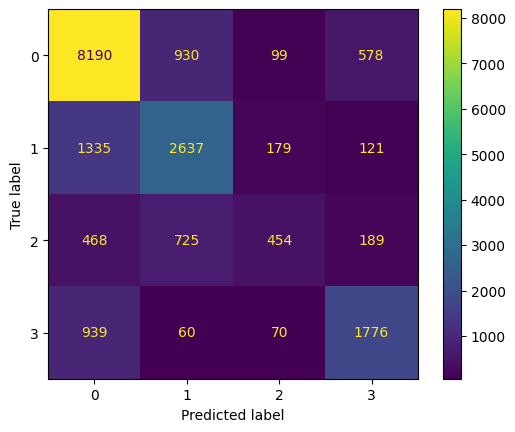

In [36]:
ConfusionMatrixDisplay.from_estimator(xtc, X_val_po, y_val)
plt.show()

In [37]:
X_val_po.shape

(18750, 364)

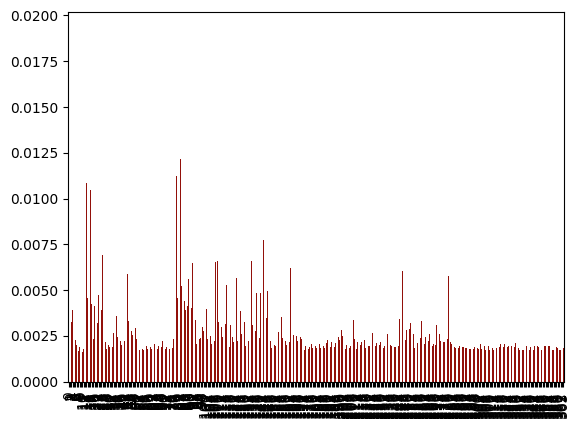

In [40]:
#std = np.std([tree.feature_importances_ for tree in xtc.estimators_], axis=0)
pd.Series(xtc.feature_importances_).plot.bar(color="#92100A")#, yerr=std)
plt.show()

In [41]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.1)
reg.fit(X_train_po, y_train)

Lasso(alpha=0.1)

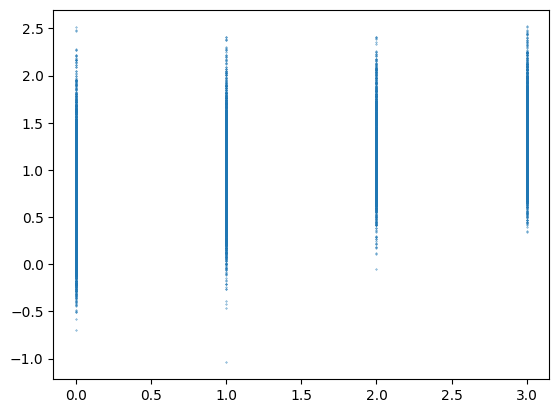

In [43]:
plt.scatter(y_val, reg.predict(X_val_po), s=0.1)
plt.show()

In [45]:
confusion_matrix(y_val, np.round(reg.predict(X_val_po)))

array([[   0,    0,    0,    0,    0],
       [   4, 2806, 6754,  232,    1],
       [   1,  511, 3441,  319,    0],
       [   0,   47, 1390,  399,    0],
       [   0,   17, 2151,  675,    2]])

In [47]:
accuracy_score(y_val, np.round(reg.predict(X_val_po)))

0.35456

Just look at [this](http://www.scholarpedia.org/article/Sitnikov_problem) and despair. Maybe $30\%$ of the feature space falls within the chaotic region. There is no place for anchors (corresponding to large, finite regions where the prediction is costant)